In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
# Check if a GPU is available
if torch.cuda.is_available():
    # Get the current device index (default is 0 if no other device is specified)
    current_device = torch.cuda.current_device()
    
    # Get the name of the GPU at this device index
    gpu_name = torch.cuda.get_device_name(current_device)
    print(f"Current GPU: {gpu_name}")
else:
    print("No GPU available.")


Current GPU: Tesla P40


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# Load the base model and tokenizer
model_id = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float32, device_map="auto") # Must be float32 for MacBooks!
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [4]:
# Load the training dataset
dataset = load_dataset("csv", data_files="../data/sarcasm.csv", split="train")

dataset

Dataset({
    features: ['question', 'answer'],
    num_rows: 199
})

In [9]:
def visualize_token_lengths(dataset, tokenizer_name="bert-base-uncased", text_column="text"):
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    # Tokenize and get lengths
    token_lengths = []
    for entry in dataset:
        tokens = tokenizer(entry[text_column], truncation=True, padding=False)
        token_lengths.append(len(tokens["input_ids"]))
    
    # Plot histogram of token lengths
    plt.figure(figsize=(10, 6))
    plt.hist(token_lengths, bins=10, color="skyblue", edgecolor="black")
    plt.title("Token Length Distribution")
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")
    plt.show()

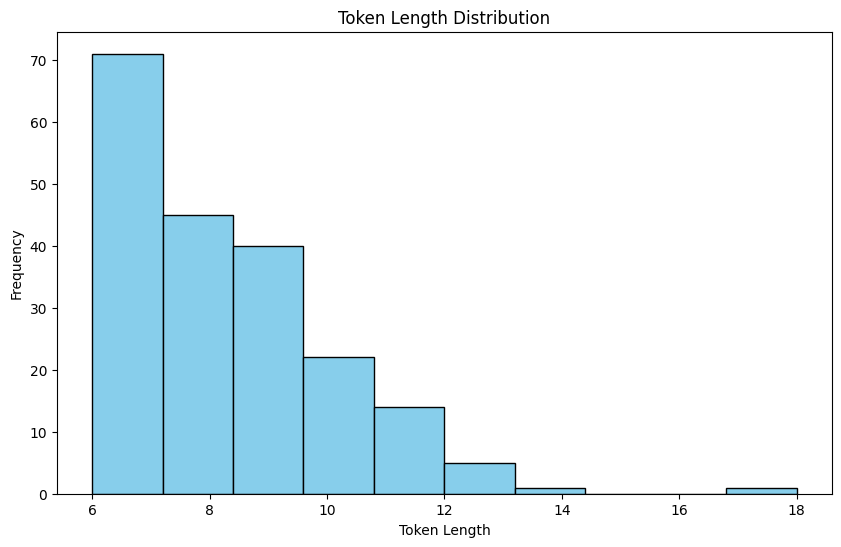

In [10]:
# Visualize token lengths
visualize_token_lengths(dataset, text_column="question")

loading file tokenizer.json from cache at /home/loc/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/loc/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/loc/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


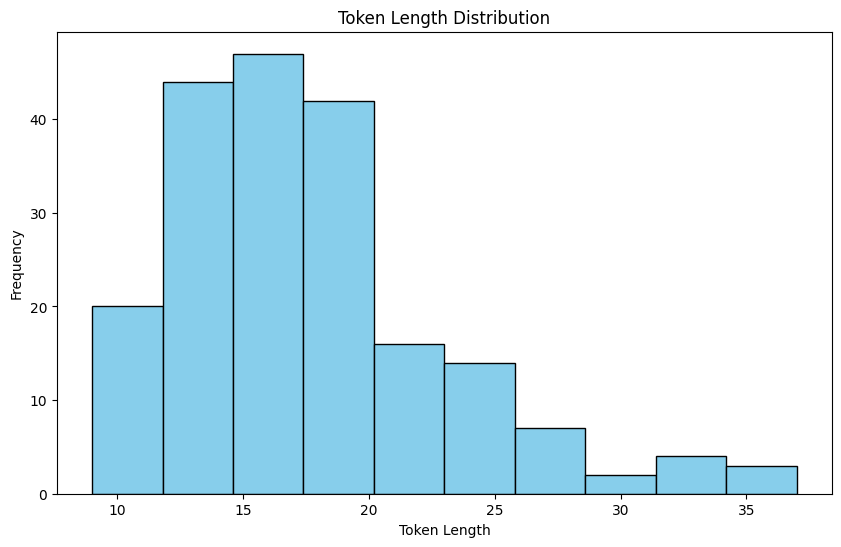

Percentiles of token lengths:
50th: 17.0
75th: 20.0
90th: 25.0
95th: 28.0
99th: 35.02000000000001
Suggested max_length (90th percentile): 25.0


In [35]:
def determine_optimal_max_length(dataset, tokenizer_name="bert-base-uncased", text_column="text"):
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    # Tokenize dataset and store token lengths
    token_lengths = [len(tokenizer(entry[text_column], truncation=False)["input_ids"]) for entry in dataset]
    
    # Plot token length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(token_lengths, bins=10, color="skyblue", edgecolor="black")
    plt.title("Token Length Distribution")
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")
    plt.show()
    
    # Calculate percentiles for token lengths
    percentiles = np.percentile(token_lengths, [50, 75, 90, 95, 99])
    print(f"Percentiles of token lengths:\n50th: {percentiles[0]}\n75th: {percentiles[1]}\n90th: {percentiles[2]}\n95th: {percentiles[3]}\n99th: {percentiles[4]}")
    
    # Suggest a max_length, e.g., 90th percentile to cover most cases
    suggested_max_length = percentiles[2]
    print(f"Suggested max_length (90th percentile): {suggested_max_length}")
    
    return suggested_max_length

# Determine optimal max_length based on token length distribution
suggested_max_length = determine_optimal_max_length(dataset, tokenizer_name=model_id,text_column="answer")

In [12]:
# Define a function to apply the chat template
def apply_chat_template(example):
    messages = [
        {"role": "user", "content": example['question']},
        {"role": "assistant", "content": example['answer']}
    ]
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    return {"prompt": prompt}

In [13]:
# Apply the chat templatefunction to the dataset
new_dataset = dataset.map(apply_chat_template)
new_dataset = new_dataset.train_test_split(0.05) # Let's keep 5% of the data for testing

In [14]:
new_dataset['train'][0]['prompt']

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nIs exercise really that important?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nOh yes, because couch potatoing doesn't require any effort at all.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

In [15]:
# Tokenize the data
def tokenize_function(example):
    # Tokenize the 'prompt' text in each example, ensuring consistent sequence length
    # padding="max_length" pads all sequences to the max length specified (128 tokens)
    # truncation=True cuts off any tokens that exceed this max length
    tokens = tokenizer(example['prompt'], padding="max_length", truncation=True, max_length=128)
    
    # Create 'labels' key to store token labels for training
    # Set padding token labels to -100 to ignore them during the loss calculation
    # The -100 label is a special value in PyTorch, meaning "ignore this position in loss computation"
    tokens['labels'] = [
        -100 if token == tokenizer.pad_token_id else token for token in tokens['input_ids']
    ]
    
    # Return the tokenized dictionary, now with 'input_ids' and 'labels' keys
    return tokens

In [16]:
# Apply tokenize_function to each row
tokenized_dataset = new_dataset.map(tokenize_function)
tokenized_dataset = tokenized_dataset.remove_columns(['question', 'answer', 'prompt'])

Map:   0%|          | 0/189 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [17]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 189
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10
    })
})

In [25]:
tokenized_dataset['train'][0]['input_ids'][:10]

[128000, 128000, 128006, 9125, 128007, 271, 38766, 1303, 33025, 2696]

In [26]:
tokenized_dataset['train'][0]['attention_mask'][:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [27]:
tokenized_dataset['train'][0]['labels'][:10]

[128000, 128000, 128006, 9125, 128007, 271, 38766, 1303, 33025, 2696]

In [28]:
# Define training arguments
model.train()
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",  # to evaluate during training
    eval_steps=40,
    logging_steps=40,
    save_steps=150,
    per_device_train_batch_size=2,  # Adjust based on your hardware
    per_device_eval_batch_size=2,
    num_train_epochs=2,  # How many times to loop through the dataset
    fp16=False,  # Must be False for MacBooks
    report_to="none", # Here we can use something like tensorboard to see the training metrics
    log_level="info",
    learning_rate=1e-5, # Would avoid larger values here
    max_grad_norm=2 # Clipping the gradients is always a good idea
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer)

In [30]:
# Train the model
trainer.train()

***** Running training *****
  Num examples = 189
  Num Epochs = 2
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 190
  Number of trainable parameters = 1,235,814,400


Step,Training Loss,Validation Loss
40,1.500100,1.359174
80,1.143400,0.974849
120,0.580000,1.007295
160,0.382900,0.930151



***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)

***** Running Evaluation *****
  Num examples = 10
  Batch size = 2

***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
Saving model checkpoint to ./results/checkpoint-150
Configuration saved in ./results/checkpoint-150/config.json
Configuration saved in ./results/checkpoint-150/generation_config.json
Model weights saved in ./results/checkpoint-150/model.safetensors
tokenizer config file saved in ./results/checkpoint-150/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-150/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
Saving model checkpoint to ./results/checkpoint-190
Configuration

TrainOutput(global_step=190, training_loss=0.8207530322827791, metrics={'train_runtime': 174.1353, 'train_samples_per_second': 2.171, 'train_steps_per_second': 1.091, 'total_flos': 282508208898048.0, 'train_loss': 0.8207530322827791, 'epoch': 2.0})

In [31]:
# Save the model and tokenizer
trainer.save_model("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")

Saving model checkpoint to ./fine-tuned-model
Configuration saved in ./fine-tuned-model/config.json
Configuration saved in ./fine-tuned-model/generation_config.json
Model weights saved in ./fine-tuned-model/model.safetensors
tokenizer config file saved in ./fine-tuned-model/tokenizer_config.json
Special tokens file saved in ./fine-tuned-model/special_tokens_map.json
tokenizer config file saved in ./fine-tuned-model/tokenizer_config.json
Special tokens file saved in ./fine-tuned-model/special_tokens_map.json


('./fine-tuned-model/tokenizer_config.json',
 './fine-tuned-model/special_tokens_map.json',
 './fine-tuned-model/tokenizer.json')